# Horizons, 3 Oceans, and Smaller Sub-Zones

This is a long notebook with 4 main sections: plotting predictability horizon maps, Splitting the oceans into 3 oceans and into smaller zones, and different plots/ways of visualizing data 

In [3]:
# Importing packages
import math
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import nc_time_axis
from dask.diagnostics import ProgressBar
import re
from xmovie import Movie
%matplotlib inline
import imageio
import math
import pandas as pd


#cartopy
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

import matplotlib.pylab as pl

THRESHOLD = 0.235559205


gridpath = ('/projects/SOCCOM/data/ESM4_PPE/archive/Richard.Slater/xanadu_esm4_20190304_mom6_ESM4_v1.0.3_rc1/GRID/ocean.static.nc')
grid = xr.open_dataset(gridpath)

In [4]:
# Loading all the calculated masked PPPs
npp_ppp = xr.open_dataset('/home/saumyam/npp_ppp_m.nc')
tos_ppp = xr.open_dataset('/home/saumyam/tos_ppp_m.nc')
sos_ppp = xr.open_dataset('/home/saumyam/sos_ppp_m.nc')
mld_ppp = xr.open_dataset('/home/saumyam/mld_ppp_m.nc')
chlos_ppp = xr.open_dataset('/home/saumyam/chlos_ppp_m.nc')

o2os_ppp = xr.open_dataset('/home/saumyam/o2os_ppp_m.nc')
no3os_ppp = xr.open_dataset('/home/saumyam/no3os_ppp_m.nc')
po4os_ppp = xr.open_dataset('/home/saumyam/po4os_ppp_m.nc')
phos_ppp = xr.open_dataset('/home/saumyam/phos_ppp_m.nc')

phycos_ppp = xr.open_dataset('/home/saumyam/phycos_ppp_m.nc')
zoocos_ppp = xr.open_dataset('/home/saumyam/zoocos_ppp_m.nc')

In [5]:
dict_names = {'tos': 'Sea Surface Temperature', 'sos': 'Sea Surface Salinity', 'MLD_003': 'Mixed Layer Depth',
             'intpp': 'Integrated Net Primary Production', 'no3os': 'Surface Nitrate'}

# PPP Horizons

Plotting horizons - the main function to plot using cartopy is plot_horizon

In [20]:
# Takes in a 120 month PPP xarray and returns a predictability horizon map
# Shows number of months for which the rolling average of a gridpoint exceeds the predictability threshold
# Default threshold is 0.235, but other thresholds can be passed as optional parameter 'threshold'
def horizon(driver, driver_ppp, threshold=THRESHOLD):
    smoothed = driver_ppp.rolling(time=12, center=True, min_periods=1).mean()
    smooth_months = xr.where(smoothed<threshold, smoothed.time,120)
    remask = smooth_months.where(driver_ppp[driver].notnull())
    minimum = remask.min(dim='time',skipna=True)
    return minimum[driver]

# Returns the predictability horizon map, no smoothing
def horizon_nosmoothing(driver, driver_ppp):
    smooth_months = xr.where(driver_ppp<THRESHOLD, driver_ppp.time,120)
    remask = smooth_months.where(driver_ppp[driver].notnull())
    minimum = remask.min(dim='time',skipna=True)
    return minimum[driver]

# Returns a visual map of how many times each gridpoint gets masked from PPP calculations
# Used for hatching, but can also be a good visual tool on its own
def wherenull(driver, driver_ppp):
    null = driver_ppp[driver].isnull() # returns a boolean array: True if null (land or masked)
    null_int = xr.where(null, 1, 0) # null_int has a 1 everywhere the ppp was null (land or masked)
    null_map = null_int.sum(dim='time') 
    null_map = null_map.where(grid['basin']!=0) # sets global_land back to null
    null_map = null_map.where(null_map>0) # gridpoints that are masked at least once
    return null_map

We can use wherenull() to see how often gridpoints have their PPP masked out using from the 10 percentile mask

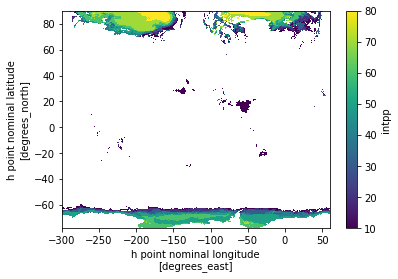

In [21]:
wherenull('intpp',npp_ppp).plot()

In [57]:
# Plots the predictability horizon using projections with cartopy
# Fairly customizable - can adjust the predictability threshold and how many months
# threshold: the threshold at which we define the ppp to be significant
#         default is 0.235 (from f test), but can pass 0.5 as threshold to see
#         high predictability
# months: optional, if you want to zoom in to see 4 years of predictability, 
#         pass 48 as parameter. Default is 120.
def plot_horizon(driver, driver_ppp, threshold=THRESHOLD, months=120):
    crsP = ccrs.Robinson()
    crsT = ccrs.PlateCarree(central_longitude=120)

    fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crsP})
    driver_horizon = horizon(driver,driver_ppp,threshold)
    
    # Specify the longitude and latitude, and the variable that you wish to plot
    # Note that here I need to get the latitude and longitude from the grid file
    X = grid['geolon']
    Y = grid['geolat']
    Z = driver_horizon # .squeeze() gets rid of unnecessary (singular) dimensions

    # Create a contour plot of SST
    # im = ax.contourf(X,Y,Z,transform=crs)
    im=ax.pcolormesh(X,Y,Z,transform=crsT,vmax=months)
    
    # Add hatching at gridpoints where the PPP is masked out at least once
    # Note: can change the 
    null = wherenull(driver,driver_ppp)
    cs = ax.contourf(
        X, Y, null.notnull(),
        transform=crsT,
        colors='none',
        levels=[0.5,1.5],
        edgecolors='white',
        hatches='..',
    )
    ax.gridlines(color='gray',linestyle='dashed')

    if threshold==THRESHOLD:
        ax.set_title(dict_names[driver],fontsize=14) # default title: just the name of the driver
    else: # indicate the threshold in the title of the plot
        ax.set_title(dict_names[driver] + ', Threshold = ' + str(threshold),fontsize=14)

    # Finally, add a colorbar
    cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05,extend='max')
    cbar.set_label('Predictability Time Horizon (Months)',fontsize=12)

/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'edgecolors'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


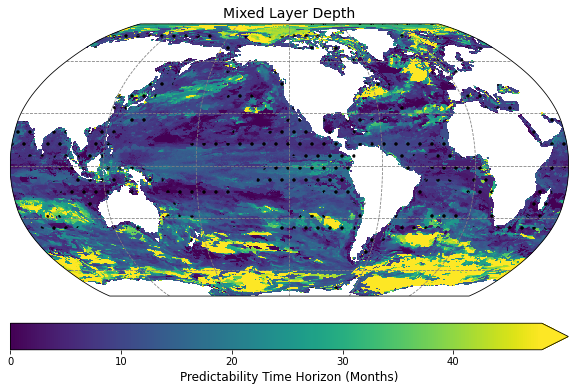

In [25]:
plot_horizon('MLD_003',mld_ppp,months=48)

/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'edgecolors'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


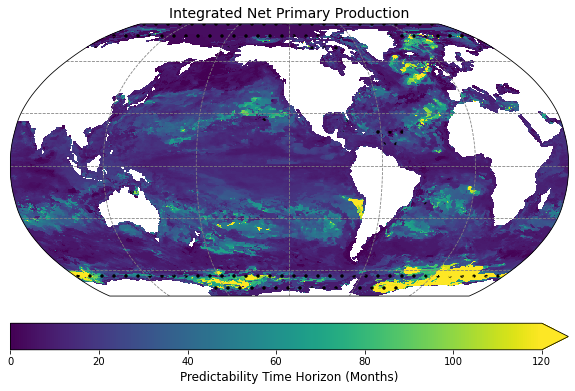

In [60]:
plot_horizon('intpp',npp_ppp)

We can use the threshold and months parameters to view high predictability, as well as to zoom in on shorter timescales.

/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/home/saumyam/.conda/envs/saumyac/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'edgecolors'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


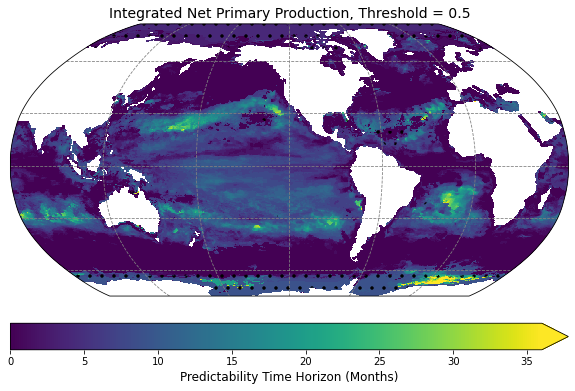

In [58]:
plot_horizon('intpp',npp_ppp,threshold=0.5,months=36)

# Oceans

The next few cells show how the entire ocean was divided into the Atlantic, Pacific, and Indian. The code is very easy to change if needed. Within this file, 'atlantic', 'pacific', and 'indian' can be passed as conditions to where() (this tends to be the easiest way to select one ocean), and the final cell represents the ocean divisions on a map in a way that can be saved to a netcdf file and used elsewhere.

## Atlantic Ocean

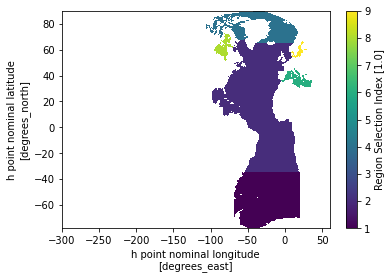

In [33]:
TDF = -68
AFRICA = 20
arctic_atlantic = (grid['geolon']>-110) & (grid['geolon']<AFRICA) & (grid['basin']==4)
atlantic = ((grid['geolon']>TDF) & (grid['basin']==1) & (grid['geolon']<AFRICA)) | (grid['basin']==2) | (arctic_atlantic) | (grid['basin']==8) | (grid['basin']==9) | (grid['basin']==6)
grid['basin'].where(atlantic).plot()

## Pacific Ocean

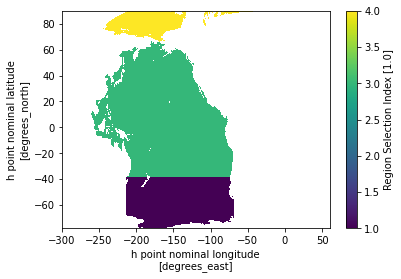

In [34]:
AUS = -180 - (180-(146.55))
s_pac = (grid['geolon']>AUS) & (grid['geolon']<TDF) & (grid['basin']==1) # southern ocean/pacific
a_pac = (grid['geolon']<-110) & (grid['geolon']>-250) & (grid['basin']==4) # arctic ocean/pacific
pacific = s_pac | a_pac | (grid['basin']==3)
grid['basin'].where(pacific).plot()

## Indian Ocean

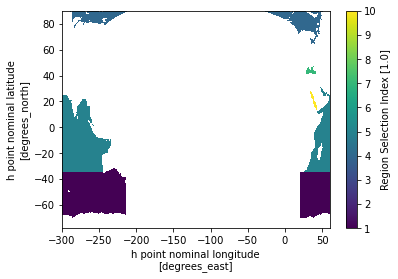

In [35]:
s_ind = ((grid['geolon']<AUS) | (grid['geolon']>AFRICA)) & (grid['basin']==1)
a_ind = ((grid['geolon']<-250) | (grid['geolon']>AFRICA)) & (grid['basin']==4)
indian = s_ind | a_ind | (grid['basin']==5) | (grid['basin']==10) | (grid['basin']==7)
grid['basin'].where(indian).plot()

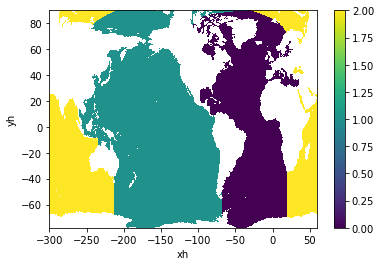

In [36]:
# Saving the Ocean separations so that they can be saved as a file and used elsewhere if desired
# 0 - Atlantic Ocean, 1 - Pacific Ocean, 2 - Indian Ocean
oceans = xr.where(atlantic,grid['basin'],1)
oceans = xr.where(atlantic,0,1)
oceans = xr.where(pacific,1,oceans)
oceans = xr.where(indian,2,oceans)
oceans = oceans.where(grid['basin']!=0) # resetting land to NaN
oceans.plot()
oceans.attrs['flag_values']='0 1 2'
oceans.attrs['flag_meanings']='atlantic_ocean pacific_ocean indian_ocean'

### Latitudinal mean of NPP

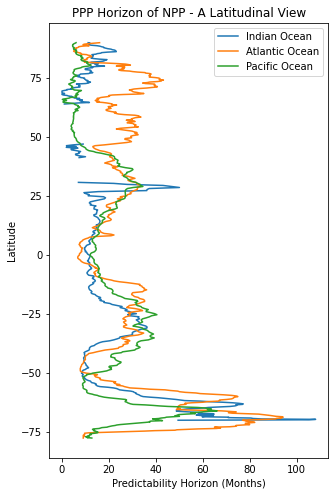

In [126]:
npp_atlantic_mean = npp_horizon.where(oceans==0).weighted(grid['areacello']).mean(['xh'])
npp_pacific = npp_horizon.where(oceans==1)
npp_pacific_mean = npp_pacific.weighted(grid['areacello']).mean(['xh'])
npp_indian = npp_horizon.where(oceans==2)
npp_indian_mean = npp_indian.weighted(grid['areacello']).mean(['xh'])

figure(figsize=(5,8))
npp_indian_mean.plot(label='Indian Ocean',y='yh')
npp_atlantic_mean.plot(label='Atlantic Ocean',y='yh')
npp_pacific_mean.plot(label='Pacific Ocean',y='yh')
plt.ylabel('Latitude')
plt.xlabel('Predictability Horizon (Months)')
plt.title('PPP Horizon of NPP - A Latitudinal View')
plt.legend()

# Zones

In [45]:
ATL = (grid['basin']==2)
PAC = (grid['basin']==3)
IND = (grid['basin']==5)
SOUTHERN = (grid['basin']==1)

north_subtropic = (grid['geolat'] > 20) & (grid['geolat'] < 45)
north_subpolar = (grid['geolat'] > 45)
equatorial = (grid['geolat'] < 20) & (grid['geolat']>-20)
south_subtropic = (grid['geolat'] < -20)
south_subpolar = (grid['geolat'] > -60)
south_polar = (grid['geolat'] < -60)

# North Subpolar
n_subp_atl = (north_subpolar) & (ATL)
n_subp_pac = (north_subpolar) & (PAC)

# North Subtropics
n_subt_atl = (north_subtropic) & (ATL)
n_subt_pac = (north_subtropic) & (PAC)

# Equatorial
eq_atl = (equatorial) & (ATL)
eq_pac = (equatorial) & (PAC)
eq_ind = (equatorial) & (IND)

# South Subtropics
s_subt_atl = (south_subtropic) & (ATL)
s_subt_pac = (south_subtropic) & (PAC)
s_subt_ind = (south_subtropic) & (IND)

# Southern Ocean - Subpolar
s_subp_atl = (south_subpolar) & (atlantic) & (SOUTHERN)
s_subp_pac = (south_subpolar) & (pacific) & (SOUTHERN)
s_subp_ind = (south_subpolar) & (indian) & (SOUTHERN)

# Southern Ocean - Polar
s_polar_atl = (south_polar) & (atlantic) & (SOUTHERN)
s_polar_pac = (south_polar) & (pacific) & (SOUTHERN)
s_polar_ind = (south_polar) & (indian) & (SOUTHERN)

arctic = grid['basin']==4
# 17 zones, including arctic ocean. Note: sea basins are included in the -1 zone

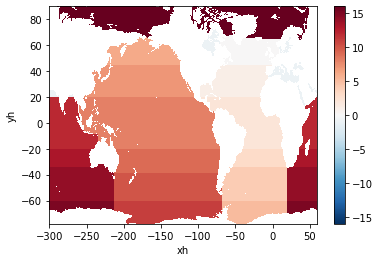

In [46]:
# Displaying zones in a basin-like map
zones = xr.where(n_subp_atl,0,-1)
zones = xr.where(n_subt_atl,1,zones)
zones = xr.where(eq_atl,2,zones)
zones = xr.where(s_subt_atl,3,zones)
zones = xr.where(s_subp_atl,4,zones)
zones = xr.where(s_polar_atl,5,zones)

zones = xr.where(n_subp_pac,6,zones)
zones = xr.where(n_subt_pac,7,zones)
zones = xr.where(eq_pac,8,zones)
zones = xr.where(s_subt_pac,9,zones)
zones = xr.where(s_subp_pac,10,zones)
zones = xr.where(s_polar_pac,11,zones)

zones = xr.where(eq_ind,12,zones)
zones = xr.where(s_subt_ind,13,zones)
zones = xr.where(s_subp_ind,14,zones)
zones = xr.where(s_polar_ind,15,zones)

zones = xr.where(grid['basin']==4,16,zones)

zones = zones.where(grid['basin']!=0)

zones.plot()
zones.to_netcdf('/home/saumyam/zones.nc')

# Plots

### Basic code for visualizing PPP change from month to month

Text(0.5, 1.0, 'PPP of Integrated NPP at All Latitudes - First 15 Months')

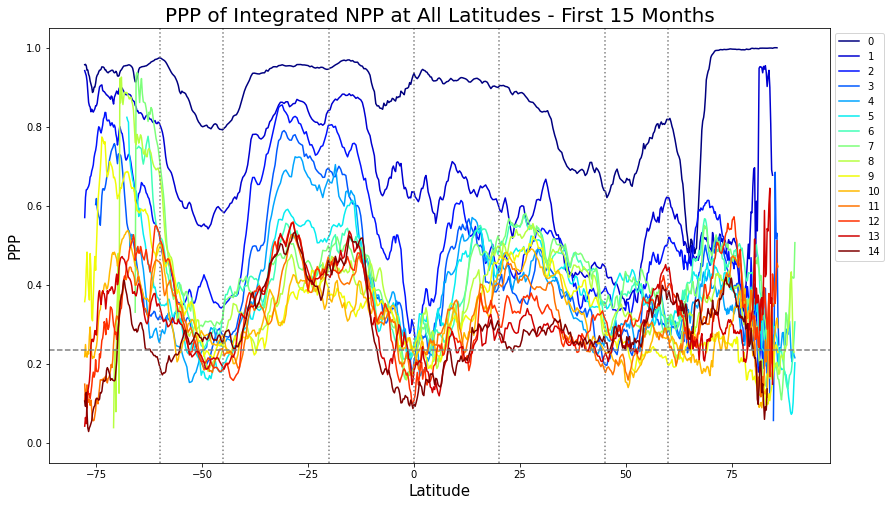

In [37]:
months = 15
colors = pl.cm.jet(np.linspace(0,1,months))
figure(figsize=(14,8))
c=0
for t in range(months):
    npp_slice = npp_ppp.isel(time=t).where(npp_ppp.isel(time=t)>0)
    time_mean = npp_slice.where(atlantic)['intpp'].weighted(grid['areacello']).mean(['xh']) 
    time_mean.plot(label=t,color=colors[t])
plt.legend(bbox_to_anchor=(1,1))


# Dashed/dotted lines for predictability threshold and latitude boundaries
plt.axhline(y=THRESHOLD, color='grey', linestyle='dashed')
plt.axvline(x=0, color='grey', linestyle='dotted')
plt.axvline(x=-20, color='grey', linestyle='dotted')
plt.axvline(x=20, color='grey', linestyle='dotted')
plt.axvline(x=45, color='grey', linestyle='dotted')
plt.axvline(x=-45, color='grey', linestyle='dotted')
plt.axvline(x=-60, color='grey', linestyle='dotted')
plt.axvline(x=60, color='grey', linestyle='dotted')



plt.xlabel('Latitude',fontsize=15)
plt.ylabel('PPP',fontsize=15)
plt.title('PPP of Integrated NPP at All Latitudes - First 15 Months',fontsize=20)

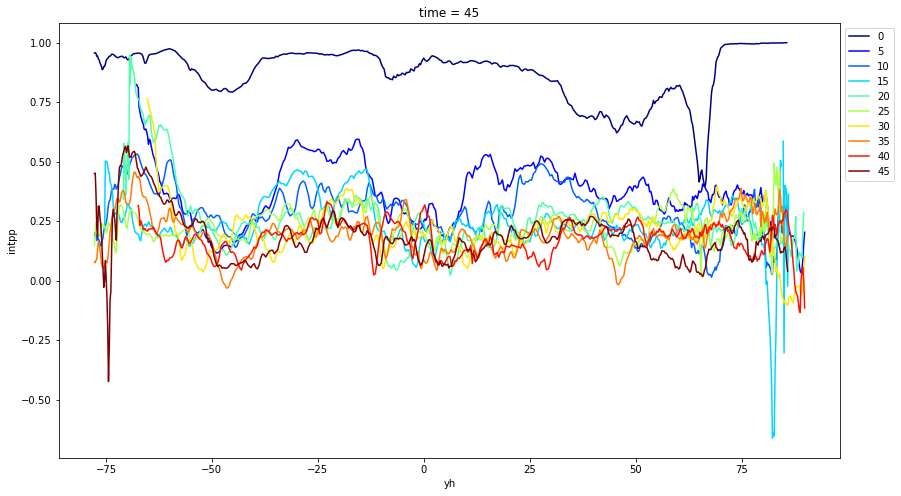

In [38]:
colors = pl.cm.jet(np.linspace(0,1,10))
figure(figsize=(14,8))
c=0
for t in range(0,50,5):
    npp_slice = npp_ppp.isel(time=t)
    time_mean = npp_slice.where(atlantic)['intpp'].weighted(grid['areacello']).mean(['xh'])
    time_mean.plot(label=t,color=colors[c])
    c = c+1
plt.legend(bbox_to_anchor=(1,1))

Text(0, 0.5, 'Latitude')

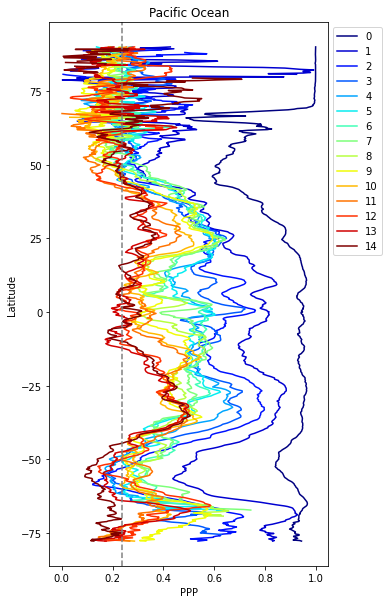

In [39]:
months = 15
colors = pl.cm.jet(np.linspace(0,1,months))
figure(figsize=(5,10))
c=0
for t in range(months):
    npp_slice = npp_ppp.isel(time=t).where(npp_ppp.isel(time=t)>0)
    time_mean = npp_slice.where(pacific)['intpp'].weighted(grid['areacello']).mean(['xh'])
    time_mean.plot(label=t,color=colors[t],y='yh')
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('PPP')
plt.title('Pacific Ocean')
plt.axvline(x=0.235, color='grey', linestyle='dashed')
plt.ylabel('Latitude')

Text(0, 0.5, 'Latitude')

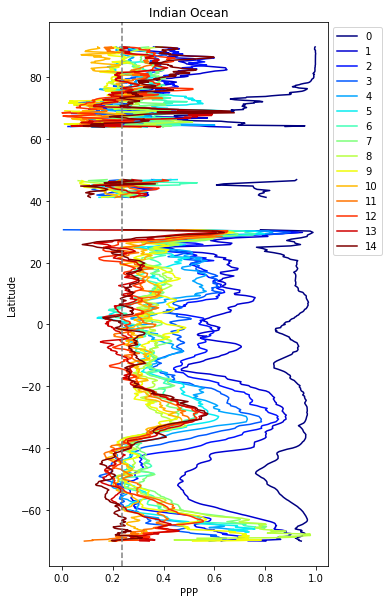

In [40]:
months = 15
colors = pl.cm.jet(np.linspace(0,1,months))
figure(figsize=(5,10))
c=0
for t in range(months):
    npp_slice = npp_ppp.isel(time=t).where(npp_ppp.isel(time=t)>0)
    time_mean = npp_slice.where(indian)['intpp'].weighted(grid['areacello']).mean(['xh'])
    time_mean.plot(label=t,color=colors[t],y='yh')
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('PPP')
plt.title('Indian Ocean')
plt.axvline(x=0.235, color='grey', linestyle='dashed')
plt.ylabel('Latitude')

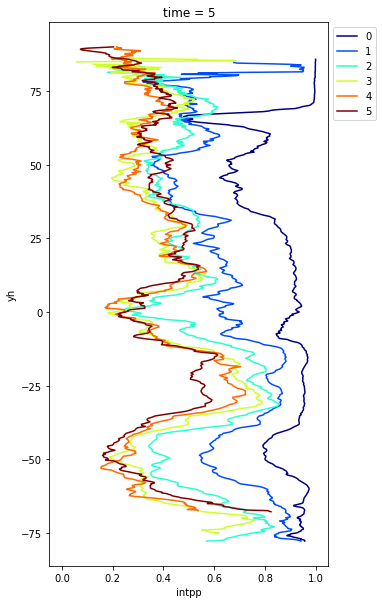

In [41]:
months = 6
colors = pl.cm.jet(np.linspace(0,1,months))
figure(figsize=(5,10))
c=0
for t in range(months):
    npp_slice = npp_ppp.isel(time=t).where(npp_ppp.isel(time=t)>0)
    time_mean = npp_slice.where(atlantic)['intpp'].weighted(grid['areacello']).mean(['xh'])
    time_mean.plot(label=t,color=colors[t],y='yh')
plt.legend(bbox_to_anchor=(1,1))


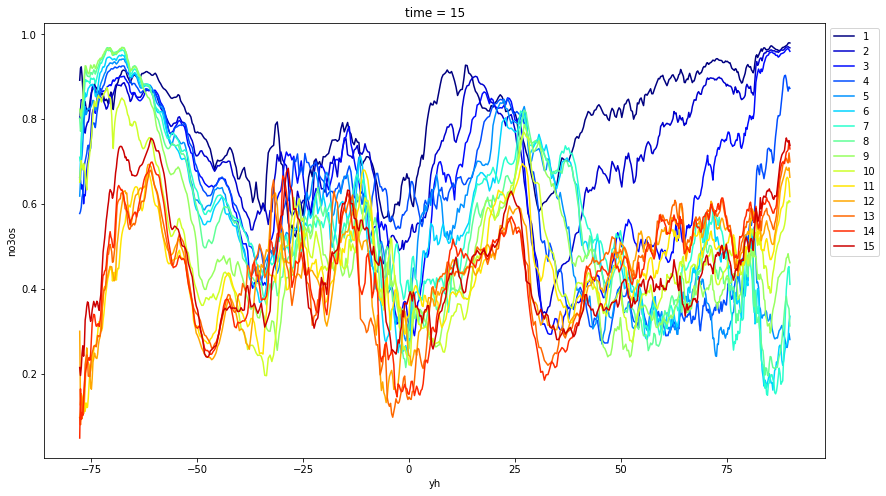

In [49]:
colors = pl.cm.jet(np.linspace(0,1,16))
figure(figsize=(14,8))
c=0
for t in range(1,16):
    no3os_slice = no3os_ppp.isel(time=t).where(no3os_ppp.isel(time=t)>0)
    time_mean = no3os_slice.where(atlantic)['no3os'].weighted(grid['areacello']).mean(['xh'])
    time_mean.plot(label=t,color=colors[c])
    c = c+1
plt.legend(bbox_to_anchor=(1,1))

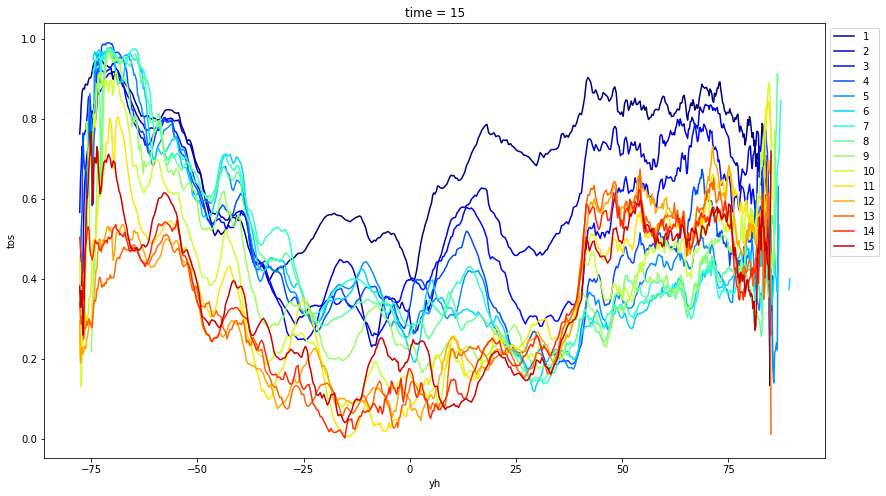

In [50]:
colors = pl.cm.jet(np.linspace(0,1,16))
figure(figsize=(14,8))
c=0
for t in range(1,16):
    tos_slice = tos_ppp.isel(time=t).where(tos_ppp.isel(time=t)>0)
    time_mean = tos_slice.where(atlantic)['tos'].weighted(grid['areacello']).mean(['xh'])
    time_mean.plot(label=t,color=colors[c])
    c = c+1
plt.legend(bbox_to_anchor=(1,1))

### Time plot of ppp over a zone

In [42]:
# Plots area-weighted mean of ppp of a set variables over a particular region
# Takes as parameter the region, in the form of a condition i.e. 'n_subt_atl' as defined above in zones
# Can pass a zone name as a region, but can also pass any condition/multiple conditions
def zonal_mean_ppp(region):
    fig,ax = plt.subplots(1,1,figsize=(8,7))
    months=[*range(0,90,3)] 
    ax.set_xticks(months)
       
    # Can change these to see other variables
    # Can also change time windows in slice(beginning,end) to zoom in on different months
    tos_slice = tos_ppp.where(region)['tos'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 60))
    no3os_slice = no3os_ppp.where(region)['no3os'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 60))
    npp_slice = npp_ppp.where(region)['intpp'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 60))
    phycos_slice = phycos_ppp.where(region)['phycos'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 60))
    mld_slice = mld_ppp.where(region)['MLD_003'].weighted(grid['areacello']).mean(['xh','yh']).sel(time=slice(0, 60))
    
    tos_slice.plot(label='tos')
    no3os_slice.plot(label='no3os')
    npp_slice.plot(label='intpp')
    #phycos_slice.plot(label='phycos')
    mld_slice.plot(label='MLD')
    plt.axhline(y=0.235, color='grey', linestyle='dashed',label='Predictability Threshold')
    plt.ylabel('PPP')
    plt.xlabel('Lead Time (months)')
    plt.legend()
    plt.show()
    

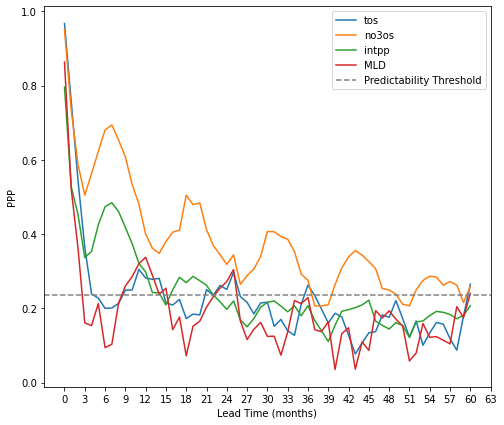

In [47]:
zonal_mean_ppp(n_subt_atl)

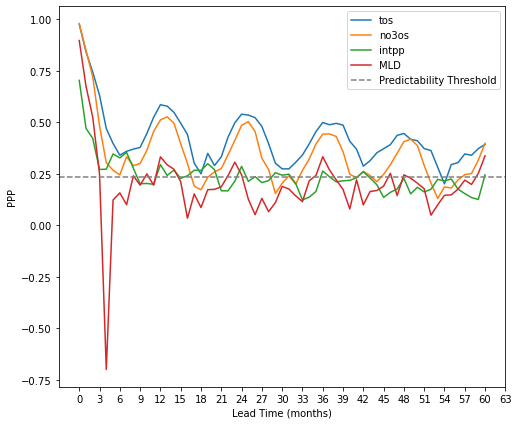

In [48]:
zonal_mean_ppp(n_subp_atl)

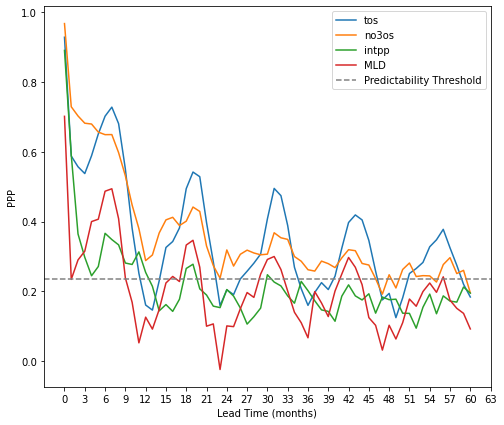

In [49]:
zonal_mean_ppp(s_subp_pac)

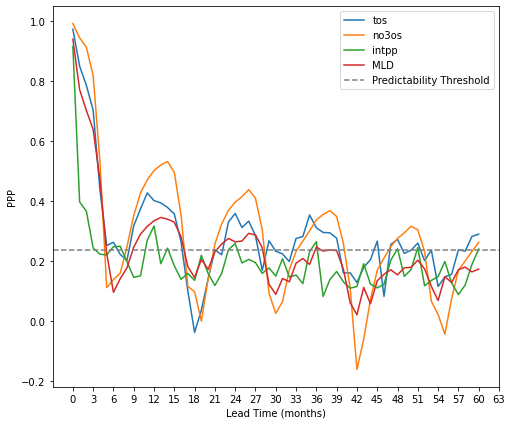

In [50]:
zonal_mean_ppp(arctic)

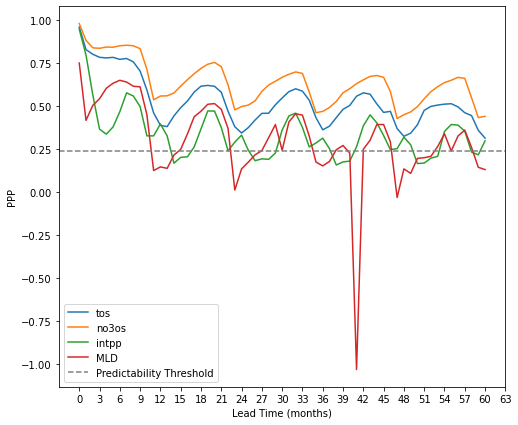

In [51]:
zonal_mean_ppp(s_polar_pac|s_polar_atl|s_polar_ind) # whole southern ocean

### Scratch space to see any combination of variables/zones together on one plot -- fill in as you please

In [70]:
zone_labels = ['north_subpolar_atlantic','north_subtropic_atlantic','equatorial_atlantic','south_subtropic_atlantic',
               'south_subpolar_atlantic','south_polar_atlantic','north_subpolar_pacific','north_subtropic_pacific',
               'equatorial_pacific','south_subtropic_pacific','south_subpolar_pacific','south_polar_pacific',
               'equatorial_indian','south_subtropic_indian','south_subpolar_indian','south_polar_indian','arctic']

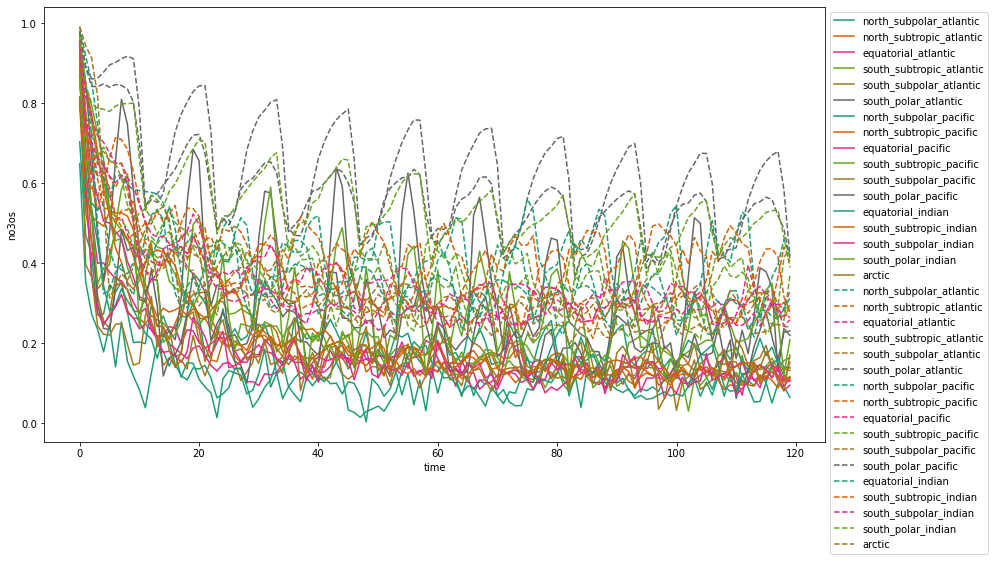

In [71]:
colors = pl.cm.Dark2(np.linspace(0,1,6))
figure(figsize=(14,8))
for zone in range(len(zone_labels)): # iterate through which zones you want (refer to zones file for numbering)
    npp_ppp.where(zones==zone)['intpp'].weighted(grid['areacello']).mean(['xh','yh']).plot(label=zone_labels[zone],color=colors[zone%6])
    no3os_ppp.where(zones==zone)['no3os'].weighted(grid['areacello']).mean(['xh','yh']).plot(label=zone_labels[zone],linestyle='dashed',color=colors[zone%6])
    # add/remove whatever variables you want
plt.legend(bbox_to_anchor=(1,1))
